In [96]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
from datasets.SP100StocksForecasting import SP100StocksForecasting
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from tqdm import trange

In [97]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

# Stock Variations Forecasting
The goal of this task is to predict the variation at the timestep $t+1$ for each stock in the S&P 100 index. The variation is defined as the percentage change in the stock price from the previous timestep. For this task, a Temporal Graph Convolutional Network ([T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://arxiv.org/pdf/1811.05320)) is used. It consists of a GCN encoder followed by a GRU decoder. The encoder is used to learn the representation of the graph at each timestep, while the decoder is used to predict the variation at the next timestep.

## Loading the data
The data from the custom PyG dataset for forecasting is loaded into a PyTorch dataloader.

In [98]:
dataset = SP100StocksForecasting()
dataset, dataset[0]

(SP100StocksForecasting(1214),
 Data(x=[20, 100, 6], edge_index=[2, 2460], y=[100, 1], edge_weight=[2460], close_price=[100, 20], close_price_y=[100, 1]))

In [99]:
test_proportion = .1
batch_size = 1  # only 1 supported for the moment

train_dataset, test_dataset = dataset[int(test_proportion * len(dataset)):], dataset[:int(test_proportion * len(dataset)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True), DataLoader(test_dataset, batch_size=1)

Train dataset: 1093, Test dataset: 121


## TGCN Model
The TGCN model consists of a GCN encoder followed by a GRU decoder. The encoder is used to learn the representation of the graph at each timestep, while the decoder is used to predict the variation at the next timestep.
The GCN part of the model encodes the nodes in the graph at each timestep, while capturing the spatial dependencies between the nodes. The GRU part of the model captures the temporal dependencies between the timestamps.

In [100]:
class GCNEncoder(nn.Module):
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int):
		super(GCNEncoder, self).__init__()
		self.conv1 = GCNConv(in_channels, hidden_size)
		self.conv2 = GCNConv(hidden_size, out_channels)
		
	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
		return self.conv2(x, edge_index, edge_weight=edge_weight)

In [101]:
class GRUDecoder(nn.Module):
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, gru_layers_nb: int = 2):
		super(GRUDecoder, self).__init__()
		self.gru = nn.GRU(in_channels, hidden_size, gru_layers_nb)
		self.linear = nn.Linear(hidden_size, out_channels)
		
	def forward(self, x: torch.tensor) -> torch.tensor:
		_, (x, _) = self.gru(x)
		x = self.linear(F.relu(x))
		return x

In [102]:
class TGCN(nn.Module):
	def __init__(self, in_channels: int, out_channels: int, gcn_hidden_size: int, gru_hidden_size: int, gru_layers_nb: int):
		super(TGCN, self).__init__()
		self.encoder = GCNEncoder(in_channels, gcn_hidden_size, gcn_hidden_size)
		self.decoder = GRUDecoder(gcn_hidden_size, out_channels, gru_hidden_size, gru_layers_nb)
		
	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		x = self.encoder(x, edge_index, edge_weight)
		x = self.decoder(x)
		return x

## Training
The model is trained using the training dataset and the Adam optimizer. The loss is calculated using the Mean Squared Error (MSE) loss function.

In [103]:
def train_iteration(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, dataloader: DataLoader, pbar: tqdm.tqdm, writer: SummaryWriter):
	for idx, data in enumerate(dataloader):
		optimizer.zero_grad()
		out = model(data.x, data.edge_index, data.edge_weight)
		loss = criterion(out, data.y)
		loss.backward()
		optimizer.step()
		pbar.set_postfix({"Loss": loss.item(), "Batch": f"{idx / len(dataloader) * 100:.1f}%"})
		writer.add_scalar("Loss/Train Loss", loss.item())

In [104]:
@torch.no_grad()
def test_iteration(model: nn.Module, criterion: nn.Module, dataloader: DataLoader, writer: SummaryWriter):
	for data in dataloader:
		out = model(data.x, data.edge_index, data.edge_weight)
		loss = criterion(out, data.y)
		writer.add_scalar("Loss/Test Loss", loss.item())

In [105]:
def train(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, num_epochs: int) -> tuple[list, list]:
	writer = SummaryWriter(f'runs/VariationForecasting_{datetime.now().strftime("%d_%m_%Hh%M")}')
	for _ in (pbar := trange(num_epochs, desc="Epochs")):
		train_iteration(model, optimizer, criterion, train_dataloader, pbar, writer)
		test_iteration(model, criterion, test_dataloader, writer)

In [106]:
def plot_loss(axs: plt.Axes, ax_idx: int, losses: list[float], title: str, color: str = "C0"):
	axs[ax_idx].plot(losses, label=title, c=color, alpha=0.5)
	axs[ax_idx].plot(range(0, len(losses)), [sum(losses[i:i+10]) / min(10, len(losses)-i) for i in range(len(losses))], label=f'{title} (avg)', c=color, lw=2)
	axs[ax_idx].set_xlabel('Batch')
	axs[ax_idx].set_ylabel('Loss')
	axs[ax_idx].set_title(title)
	axs[ax_idx].grid()

In [107]:
in_channels, out_channels, gcn_hidden_size, gru_hidden_size, gru_layers_nb = dataset.num_features, 1, 32, 32, 2
model = TGCN(in_channels, out_channels, gcn_hidden_size, gru_hidden_size, gru_layers_nb)
model

TGCN(
  (encoder): GCNEncoder(
    (conv1): GCNConv(6, 32)
    (conv2): GCNConv(32, 32)
  )
  (decoder): GRUDecoder(
    (gru): GRU(32, 32, num_layers=2)
    (linear): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [108]:
lr, num_epochs = 0.005, 4

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [109]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs)

Epochs: 100%|██████████| 4/4 [07:13<00:00, 108.33s/it, Loss=3.59, Batch=99.9%] 


## Results
The model tries to forecast the variations one timestep ahead for four stocks. The real values are plotted against the forecasted values.

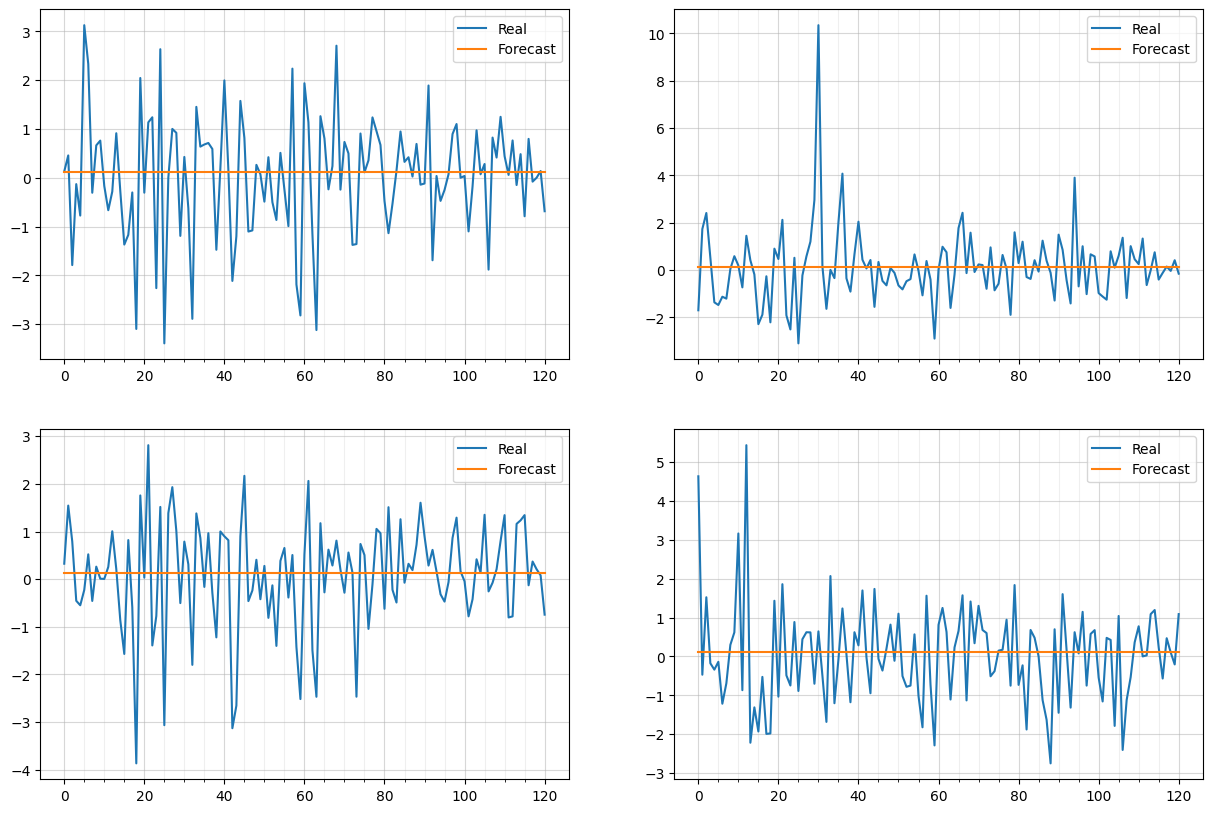

In [111]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

data = test_dataloader
forecasts = np.array([
	model(g.x, g.edge_index, g.edge_weight).detach().numpy() for g in data
]).reshape((len(data), -1))
target = np.array([g.y.numpy() for g in data]).reshape((len(data), -1))

stocks_idx = np.random.choice(target.shape[1], 4)
for idx, stock_idx in enumerate(stocks_idx):
	axs[idx // 2, idx % 2].plot(target[:, stock_idx], label="Real")
	axs[idx // 2, idx % 2].plot(forecasts[:, stock_idx], label="Forecast")
	axs[idx // 2, idx % 2].legend()
	axs[idx // 2, idx % 2].set_xticks(range(0, len(data), 5), minor=True)
	axs[idx // 2, idx % 2].grid(which='minor', alpha=0.2)
	axs[idx // 2, idx % 2].grid(which='major', alpha=0.5)
	
plt.show()